In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception
import pandas as pd
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = r'/content/drive/MyDrive/datasets/Massachusetts Roads Dataset/tiff'
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, 'train')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train_labels')

VAL_IMG_DIR = os.path.join(DATASET_PATH, 'val')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val_labels')

TEST_IMG_DIR = os.path.join(DATASET_PATH, 'test')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test_labels')

print("train Images:", len(os.listdir(TRAIN_IMG_DIR)))
print("train Masks :", len(os.listdir(TRAIN_MASK_DIR)))
print("val Images  :", len(os.listdir(VAL_IMG_DIR)))
print("val Masks   :", len(os.listdir(VAL_MASK_DIR)))
print("test Images :", len(os.listdir(TEST_IMG_DIR)))
print("test Masks  :", len(os.listdir(TEST_MASK_DIR)))


train Images: 1108
train Masks : 1108
val Images  : 14
val Masks   : 14
test Images : 49
test Masks  : 49


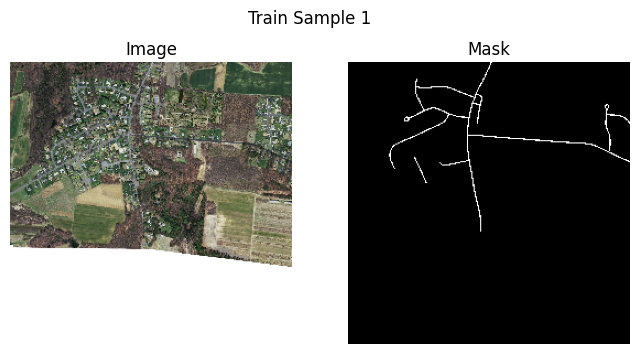

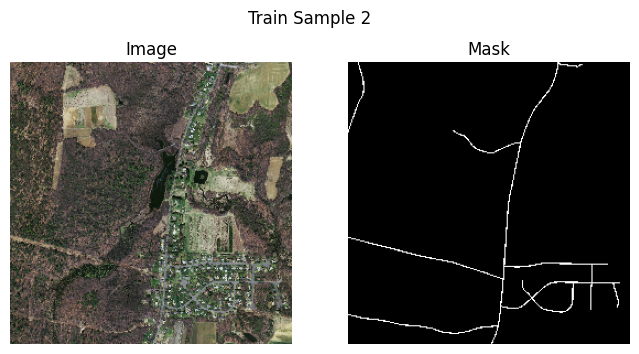

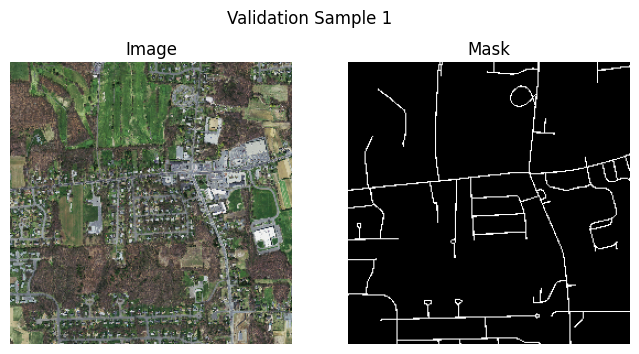

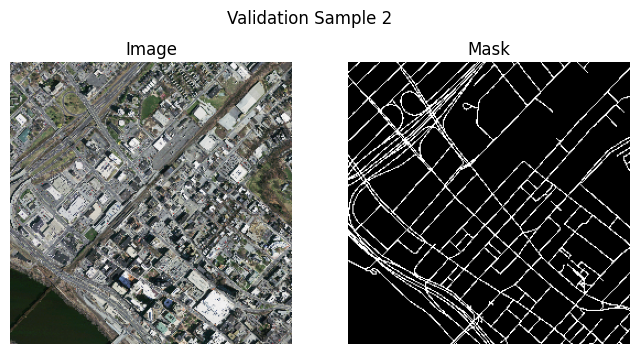

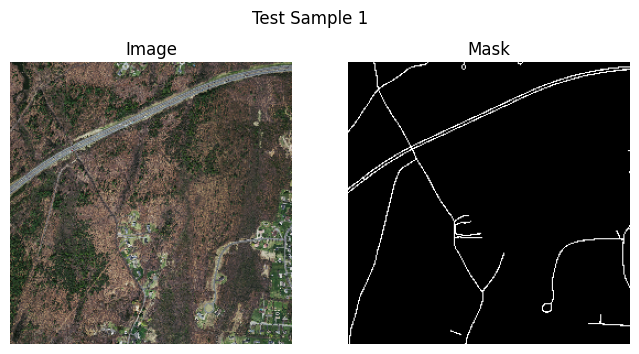

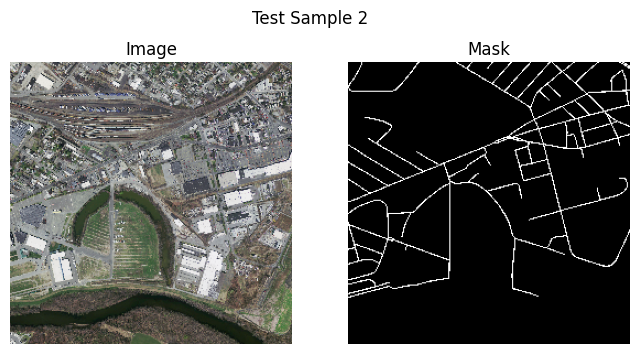

In [ ]:
import cv2

def load_and_preprocess(image_path, mask_path, img_size=256):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size)) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = np.where(mask > 127, 1, 0)
    return img, mask

def visualize_samples(img_dir, mask_dir, title):
    img_files = sorted([os.path.join(img_dir, x) for x in os.listdir(img_dir) if x.endswith(('.tif', '.tiff', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, x) for x in os.listdir(mask_dir) if x.endswith(('.tif', '.tiff', '.png', '.jpg'))])

    for i in range(2):
        img, mask = load_and_preprocess(img_files[i], mask_files[i])

        plt.figure(figsize=(8, 4))
        plt.suptitle(f"{title} Sample {i+1}")

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()

visualize_samples(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "Train")
visualize_samples(VAL_IMG_DIR, VAL_MASK_DIR, "Validation")
visualize_samples(TEST_IMG_DIR, TEST_MASK_DIR, "Test")


In [ ]:
import cv2

IMG_SIZE = 256
BATCH_SIZE = 8

def load_image_and_mask_numpy(image_path, mask_path):
    image_path = image_path.decode()
    mask_path = mask_path.decode()

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img.astype(np.float32), mask

def load_image_and_mask(image_path, mask_path):
    img, mask = tf.numpy_function(
        load_image_and_mask_numpy,
        [image_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return img, mask

def get_file_lists(img_dir, mask_dir):
    img_files = sorted([
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
        if fname.endswith('.tiff')
    ])
    mask_files = sorted([
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith('.tif')
    ])
    return img_files, mask_files

train_imgs, train_masks = get_file_lists(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_imgs, val_masks = get_file_lists(VAL_IMG_DIR, VAL_MASK_DIR)
test_imgs, test_masks = get_file_lists(TEST_IMG_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_imgs)} images, {len(train_masks)} masks")
print(f"Val  : {len(val_imgs)} images, {len(val_masks)} masks")
print(f"Test : {len(test_imgs)} images, {len(test_masks)} masks")

def create_dataset(img_list, mask_list, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=50)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_imgs, train_masks, shuffle=True)
val_ds = create_dataset(val_imgs, val_masks)
test_ds = create_dataset(test_imgs, test_masks)

print(" Datasets are ready for training with U-Net.")


Train: 1108 images, 1108 masks
Val  : 14 images, 14 masks
Test : 49 images, 49 masks
✅ Datasets are ready for training with U-Net.


In [ ]:

from tensorflow.keras import layers, models

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[iou_metric, tf.keras.metrics.BinaryAccuracy()]
)

print("Model compiled successfully and ready for training!")


Model compiled successfully and ready for training!


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9249 - iou_metric: 0.0022 - loss: 1.3061

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)



Epoch 1: val_iou_metric improved from -inf to 0.00000, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 1011s 7s/step - binary_accuracy: 0.9251 - iou_metric: 0.0022 - loss: 1.3055 - val_binary_accuracy: 0.9309 - val_iou_metric: 3.3291e-11 - val_loss: 1.1874 - learning_rate: 1.0000e-04
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - binary_accuracy: 0.9557 - iou_metric: 4.8903e-11 - loss: 1.0978
Epoch 2: val_iou_metric did not improve from 0.00000
139/139 ━━━━━━━━━━━━━━━━━━━━ 104s 449ms/step - binary_accuracy: 0.9557 - iou_metric: 4.8904e-11 - loss: 1.0977 - val_binary_accuracy: 0.9309 - val_iou_metric: 3.3288e-11 - val_loss: 1.0774 - learning_rate: 1.0000e-04
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.9507 - iou_metric: 0.0411 - loss: 1.0125
Epoch 3: val_iou_metric improved from 0.00000 to 0.10108, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - binary_accuracy: 0.9506 - iou_metric: 0.0414 - loss: 1.0125 - val_binary_accuracy: 0.9194 - val_iou_metric: 0.1011 - val_loss: 1.0977 - learning_rate: 1.0000e-04
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - binary_accuracy: 0.9384 - iou_metric: 0.1558 - loss: 0.9433
Epoch 4: val_iou_metric improved from 0.10108 to 0.19892, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 470ms/step - binary_accuracy: 0.9384 - iou_metric: 0.1559 - loss: 0.9433 - val_binary_accuracy: 0.9125 - val_iou_metric: 0.1989 - val_loss: 0.9678 - learning_rate: 1.0000e-04
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.9439 - iou_metric: 0.2210 - loss: 0.8543
Epoch 5: val_iou_metric improved from 0.19892 to 0.23150, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - binary_accuracy: 0.9439 - iou_metric: 0.2210 - loss: 0.8543 - val_binary_accuracy: 0.9115 - val_iou_metric: 0.2315 - val_loss: 0.9510 - learning_rate: 1.0000e-04
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - binary_accuracy: 0.9478 - iou_metric: 0.2478 - loss: 0.8146
Epoch 6: val_iou_metric improved from 0.23150 to 0.24973, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - binary_accuracy: 0.9478 - iou_metric: 0.2478 - loss: 0.8147 - val_binary_accuracy: 0.9180 - val_iou_metric: 0.2497 - val_loss: 0.9065 - learning_rate: 1.0000e-04
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - binary_accuracy: 0.9498 - iou_metric: 0.2688 - loss: 0.7840
Epoch 7: val_iou_metric improved from 0.24973 to 0.26453, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 460ms/step - binary_accuracy: 0.9498 - iou_metric: 0.2688 - loss: 0.7841 - val_binary_accuracy: 0.9209 - val_iou_metric: 0.2645 - val_loss: 0.8777 - learning_rate: 1.0000e-04
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - binary_accuracy: 0.9537 - iou_metric: 0.2970 - loss: 0.7405
Epoch 8: val_iou_metric improved from 0.26453 to 0.29663, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 465ms/step - binary_accuracy: 0.9536 - iou_metric: 0.2969 - loss: 0.7407 - val_binary_accuracy: 0.9228 - val_iou_metric: 0.2966 - val_loss: 0.8290 - learning_rate: 1.0000e-04
Epoch 9/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - binary_accuracy: 0.9562 - iou_metric: 0.3147 - loss: 0.7158
Epoch 9: val_iou_metric improved from 0.29663 to 0.30620, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 478ms/step - binary_accuracy: 0.9561 - iou_metric: 0.3147 - loss: 0.7159 - val_binary_accuracy: 0.9264 - val_iou_metric: 0.3062 - val_loss: 0.8130 - learning_rate: 1.0000e-04
Epoch 10/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - binary_accuracy: 0.9578 - iou_metric: 0.3353 - loss: 0.6869
Epoch 10: val_iou_metric improved from 0.30620 to 0.31630, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 478ms/step - binary_accuracy: 0.9577 - iou_metric: 0.3353 - loss: 0.6871 - val_binary_accuracy: 0.9346 - val_iou_metric: 0.3163 - val_loss: 0.7916 - learning_rate: 1.0000e-04
Epoch 11/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - binary_accuracy: 0.9597 - iou_metric: 0.3520 - loss: 0.6630
Epoch 11: val_iou_metric improved from 0.31630 to 0.34234, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 472ms/step - binary_accuracy: 0.9597 - iou_metric: 0.3519 - loss: 0.6632 - val_binary_accuracy: 0.9317 - val_iou_metric: 0.3423 - val_loss: 0.7591 - learning_rate: 1.0000e-04
Epoch 12/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.9609 - iou_metric: 0.3685 - loss: 0.6416
Epoch 12: val_iou_metric improved from 0.34234 to 0.34794, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 460ms/step - binary_accuracy: 0.9608 - iou_metric: 0.3684 - loss: 0.6418 - val_binary_accuracy: 0.9353 - val_iou_metric: 0.3479 - val_loss: 0.7537 - learning_rate: 1.0000e-04
Epoch 13/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.9624 - iou_metric: 0.3810 - loss: 0.6247
Epoch 13: val_iou_metric improved from 0.34794 to 0.35495, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - binary_accuracy: 0.9624 - iou_metric: 0.3809 - loss: 0.6249 - val_binary_accuracy: 0.9378 - val_iou_metric: 0.3550 - val_loss: 0.7417 - learning_rate: 1.0000e-04
Epoch 14/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - binary_accuracy: 0.9632 - iou_metric: 0.3940 - loss: 0.6088
Epoch 14: val_iou_metric did not improve from 0.35495
139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 453ms/step - binary_accuracy: 0.9632 - iou_metric: 0.3938 - loss: 0.6091 - val_binary_accuracy: 0.9396 - val_iou_metric: 0.3330 - val_loss: 0.7764 - learning_rate: 1.0000e-04
Epoch 15/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - binary_accuracy: 0.9640 - iou_metric: 0.3950 - loss: 0.6051
Epoch 15: val_iou_metric improved from 0.35495 to 0.36947, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 491ms/step - binary_accuracy: 0.9640 - iou_metric: 0.3949 - loss: 0.6053 - val_binary_accuracy: 0.9416 - val_iou_metric: 0.3695 - val_loss: 0.7179 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


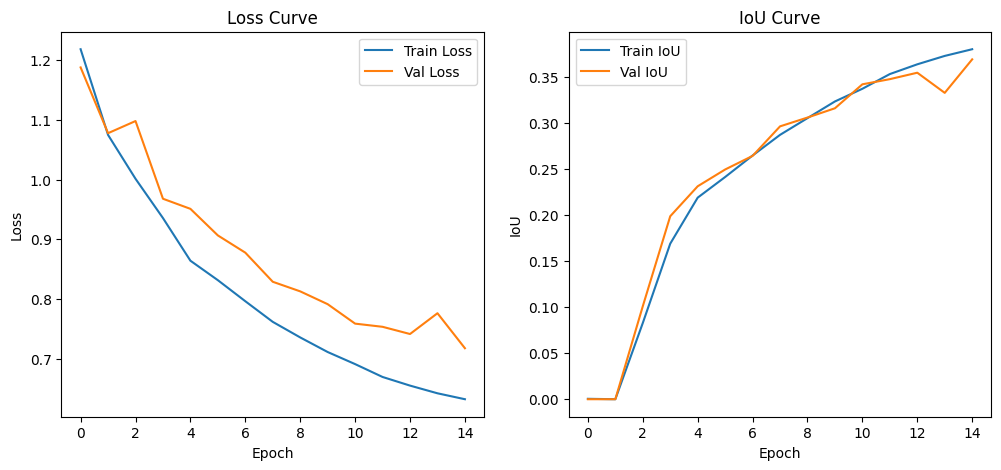

In [ ]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_roads.h5',
    monitor='val_iou_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_metric',
    mode='max',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - binary_accuracy: 0.9679 - iou_metric: 0.4345 - loss: 0.5538

Test Results:
Loss         : 0.5710
IoU          : 0.4377
Accuracy     : 0.9637


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


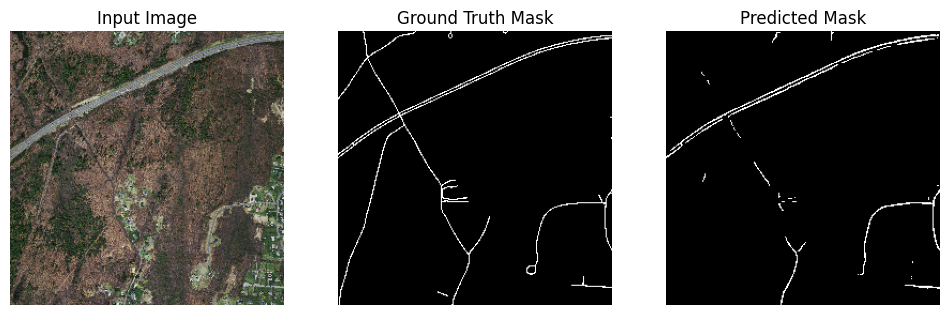

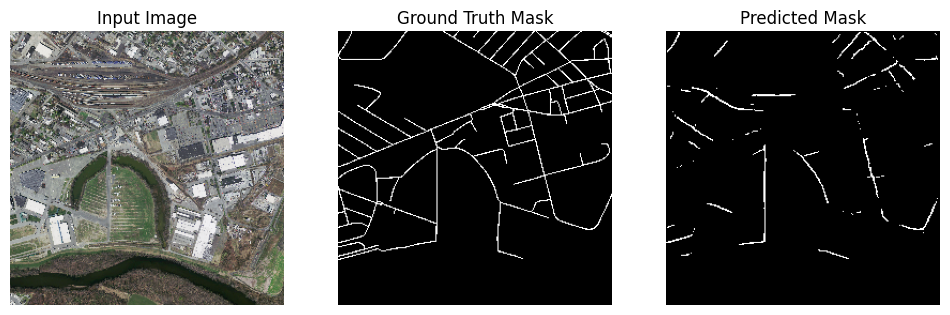

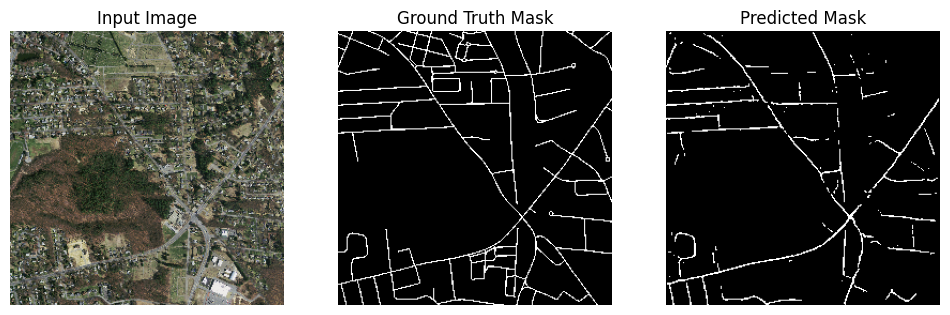

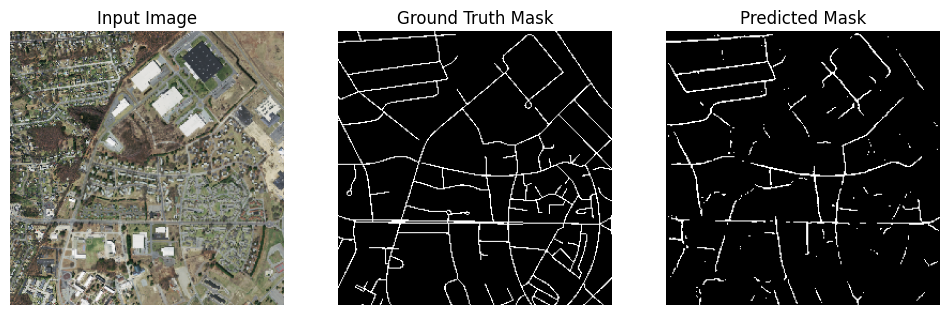

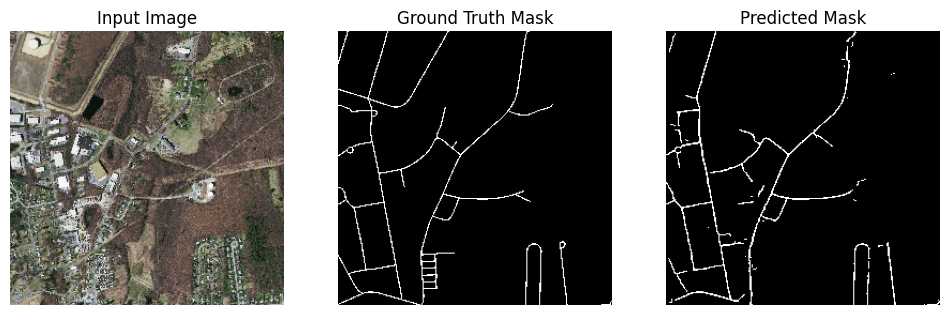

In [ ]:

model.load_weights('best_unet_roads.h5')

results = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Loss         : {results[0]:.4f}")
print(f"IoU          : {results[1]:.4f}")
print(f"Accuracy     : {results[2]:.4f}")

def visualize_predictions(dataset, num_samples=5):
    for imgs, masks in dataset.take(1):
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(imgs[i])
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions(test_ds, num_samples=5)


In [ ]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1] + 25,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 16/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - binary_accuracy: 0.9650 - iou_metric: 0.4143 - loss: 0.5810
Epoch 16: val_iou_metric improved from 0.36947 to 0.38704, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 467ms/step - binary_accuracy: 0.9650 - iou_metric: 0.4142 - loss: 0.5813 - val_binary_accuracy: 0.9391 - val_iou_metric: 0.3870 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 17/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - binary_accuracy: 0.9657 - iou_metric: 0.4219 - loss: 0.5709
Epoch 17: val_iou_metric did not improve from 0.38704
139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 450ms/step - binary_accuracy: 0.9657 - iou_metric: 0.4217 - loss: 0.5711 - val_binary_accuracy: 0.9450 - val_iou_metric: 0.3510 - val_loss: 0.7628 - learning_rate: 1.0000e-04
Epoch 18/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - binary_accuracy: 0.9660 - iou_metric: 0.4237 - loss: 0.5704
Epoch 18: val_iou_metric improved from 0.38704 to 0.40814, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 457ms/step - binary_accuracy: 0.9659 - iou_metric: 0.4235 - loss: 0.5706 - val_binary_accuracy: 0.9434 - val_iou_metric: 0.4081 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 19/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - binary_accuracy: 0.9671 - iou_metric: 0.4372 - loss: 0.5515
Epoch 19: val_iou_metric did not improve from 0.40814
139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 449ms/step - binary_accuracy: 0.9670 - iou_metric: 0.4370 - loss: 0.5518 - val_binary_accuracy: 0.9467 - val_iou_metric: 0.3900 - val_loss: 0.7009 - learning_rate: 1.0000e-04
Epoch 20/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - binary_accuracy: 0.9671 - iou_metric: 0.4394 - loss: 0.5521
Epoch 20: val_iou_metric improved from 0.40814 to 0.41178, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 470ms/step - binary_accuracy: 0.9671 - iou_metric: 0.4393 - loss: 0.5523 - val_binary_accuracy: 0.9459 - val_iou_metric: 0.4118 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 21/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - binary_accuracy: 0.9682 - iou_metric: 0.4491 - loss: 0.5380
Epoch 21: val_iou_metric did not improve from 0.41178
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 457ms/step - binary_accuracy: 0.9682 - iou_metric: 0.4489 - loss: 0.5383 - val_binary_accuracy: 0.9476 - val_iou_metric: 0.3725 - val_loss: 0.7313 - learning_rate: 1.0000e-04
Epoch 22/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - binary_accuracy: 0.9681 - iou_metric: 0.4496 - loss: 0.5392
Epoch 22: val_iou_metric did not improve from 0.41178
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 461ms/step - binary_accuracy: 0.9681 - iou_metric: 0.4494 - loss: 0.5394 - val_binary_accuracy: 0.9481 - val_iou_metric: 0.4094 - val_loss: 0.6653 - learning_rate: 1.0000e-04
Epoch 23/39
139/139 ━━━━━━━━━━━━━━

139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 475ms/step - binary_accuracy: 0.9689 - iou_metric: 0.4553 - loss: 0.5291 - val_binary_accuracy: 0.9483 - val_iou_metric: 0.4252 - val_loss: 0.6446 - learning_rate: 1.0000e-04
Epoch 24/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - binary_accuracy: 0.9695 - iou_metric: 0.4678 - loss: 0.5144
Epoch 24: val_iou_metric improved from 0.42522 to 0.42713, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 488ms/step - binary_accuracy: 0.9695 - iou_metric: 0.4676 - loss: 0.5147 - val_binary_accuracy: 0.9483 - val_iou_metric: 0.4271 - val_loss: 0.6428 - learning_rate: 1.0000e-04
Epoch 25/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.9698 - iou_metric: 0.4718 - loss: 0.5110
Epoch 25: val_iou_metric improved from 0.42713 to 0.43208, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 459ms/step - binary_accuracy: 0.9697 - iou_metric: 0.4717 - loss: 0.5112 - val_binary_accuracy: 0.9486 - val_iou_metric: 0.4321 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 26/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - binary_accuracy: 0.9704 - iou_metric: 0.4842 - loss: 0.4970
Epoch 26: val_iou_metric improved from 0.43208 to 0.44806, saving model to best_unet_roads.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 466ms/step - binary_accuracy: 0.9704 - iou_metric: 0.4840 - loss: 0.4972 - val_binary_accuracy: 0.9490 - val_iou_metric: 0.4481 - val_loss: 0.6156 - learning_rate: 1.0000e-04
Epoch 27/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - binary_accuracy: 0.9709 - iou_metric: 0.4899 - loss: 0.4903
Epoch 27: val_iou_metric did not improve from 0.44806
139/139 ━━━━━━━━━━━━━━━━━━━━ 90s 626ms/step - binary_accuracy: 0.9709 - iou_metric: 0.4898 - loss: 0.4905 - val_binary_accuracy: 0.9495 - val_iou_metric: 0.4311 - val_loss: 0.6459 - learning_rate: 1.0000e-04
Epoch 28/39
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - binary_accuracy: 0.9715 - iou_metric: 0.4924 - loss: 0.4872
Epoch 28: val_iou_metric did not improve from 0.44806
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 450ms/step - binary_accuracy: 0.9715 - iou_metric: 0.4922 - loss: 0.4874 - val_binary_accuracy: 0.9506 - val_iou_metric: 0.4365 - val_loss: 0.6341 - learning_rate: 1.0000e-04
Epoch 29/39
139/139 ━━━━━━━━━━━━━

In [ ]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1] + 15,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 16/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - binary_accuracy: 0.9710 - iou_metric: 0.4882 - loss: 0.4919
Epoch 16: val_iou_metric did not improve from 0.44806
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 484ms/step - binary_accuracy: 0.9710 - iou_metric: 0.4880 - loss: 0.4921 - val_binary_accuracy: 0.9494 - val_iou_metric: 0.4469 - val_loss: 0.6153 - learning_rate: 5.0000e-05
Epoch 17/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - binary_accuracy: 0.9715 - iou_metric: 0.4953 - loss: 0.4832
Epoch 17: val_iou_metric did not improve from 0.44806
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - binary_accuracy: 0.9715 - iou_metric: 0.4951 - loss: 0.4834 - val_binary_accuracy: 0.9494 - val_iou_metric: 0.4368 - val_loss: 0.6258 - learning_rate: 5.0000e-05
Epoch 18/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - binary_accuracy: 0.9717 - iou_metric: 0.4952 - loss: 0.4829
Epoch 18: val_iou_metric did not improve from 0.44806
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 484ms/step - binary_accuracy: 0.9716 -

139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 485ms/step - binary_accuracy: 0.9724 - iou_metric: 0.5061 - loss: 0.4719 - val_binary_accuracy: 0.9492 - val_iou_metric: 0.4507 - val_loss: 0.6101 - learning_rate: 5.0000e-05
Epoch 20/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - binary_accuracy: 0.9728 - iou_metric: 0.5035 - loss: 0.4736
Epoch 20: val_iou_metric did not improve from 0.45070
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 457ms/step - binary_accuracy: 0.9728 - iou_metric: 0.5034 - loss: 0.4738 - val_binary_accuracy: 0.9497 - val_iou_metric: 0.4429 - val_loss: 0.6247 - learning_rate: 5.0000e-05
Epoch 21/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - binary_accuracy: 0.9729 - iou_metric: 0.5089 - loss: 0.4681
Epoch 21: val_iou_metric did not improve from 0.45070
139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 450ms/step - binary_accuracy: 0.9729 - iou_metric: 0.5088 - loss: 0.4683 - val_binary_accuracy: 0.9504 - val_iou_metric: 0.4463 - val_loss: 0.6211 - learning_rate: 5.0000e-05
Epoch 22/29
139/139 ━━━━━━━━━━━━━━

139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 466ms/step - binary_accuracy: 0.9741 - iou_metric: 0.5266 - loss: 0.4480 - val_binary_accuracy: 0.9494 - val_iou_metric: 0.4534 - val_loss: 0.6088 - learning_rate: 5.0000e-05
Epoch 25/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - binary_accuracy: 0.9745 - iou_metric: 0.5377 - loss: 0.4370
Epoch 25: val_iou_metric did not improve from 0.45335
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 456ms/step - binary_accuracy: 0.9745 - iou_metric: 0.5376 - loss: 0.4372 - val_binary_accuracy: 0.9498 - val_iou_metric: 0.4485 - val_loss: 0.6150 - learning_rate: 5.0000e-05
Epoch 26/29
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - binary_accuracy: 0.9751 - iou_metric: 0.5438 - loss: 0.4297
Epoch 26: val_iou_metric did not improve from 0.45335
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 477ms/step - binary_accuracy: 0.9751 - iou_metric: 0.5436 - loss: 0.4299 - val_binary_accuracy: 0.9488 - val_iou_metric: 0.4493 - val_loss: 0.6177 - learning_rate: 5.0000e-05
Epoch 27/29
139/139 ━━━━━━━━━━━━━━

In [ ]:
model.load_weights('best_unet_roads.h5')
results = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Loss         : {results[0]:.4f}")
print(f"IoU          : {results[1]:.4f}")
print(f"Accuracy     : {results[2]:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - binary_accuracy: 0.9721 - iou_metric: 0.5069 - loss: 0.4668

Test Results:
Loss         : 0.4850
IoU          : 0.5078
Accuracy     : 0.9686


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


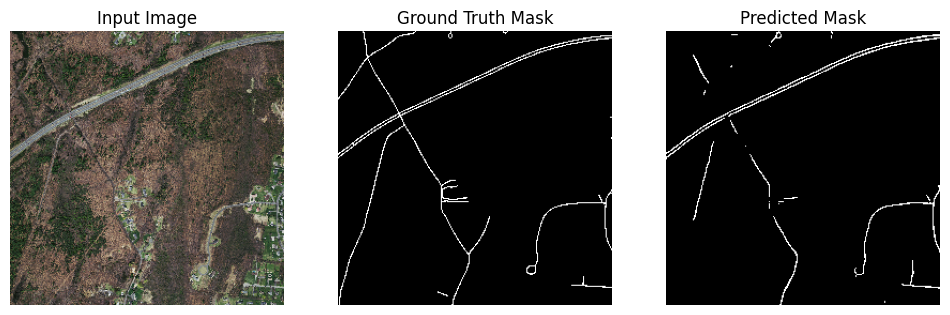

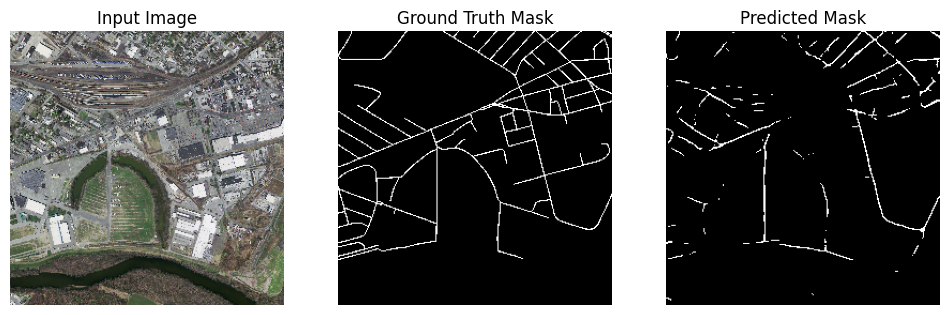

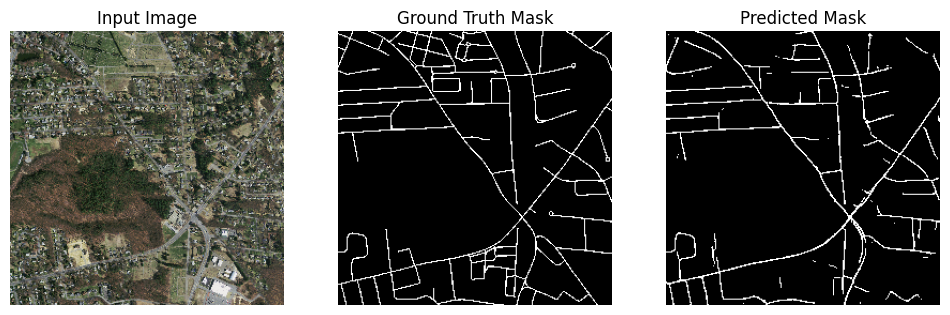

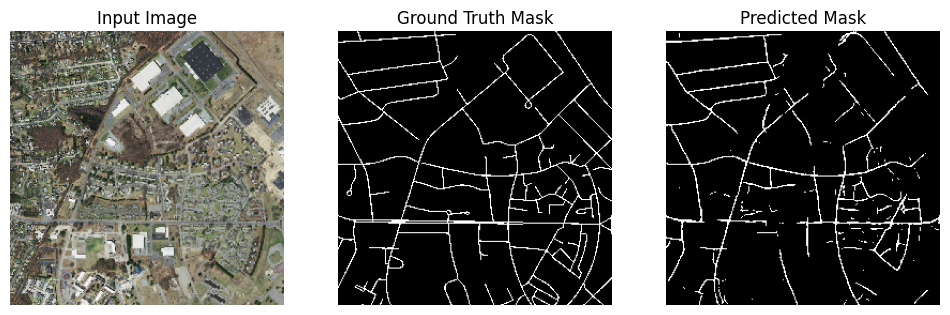

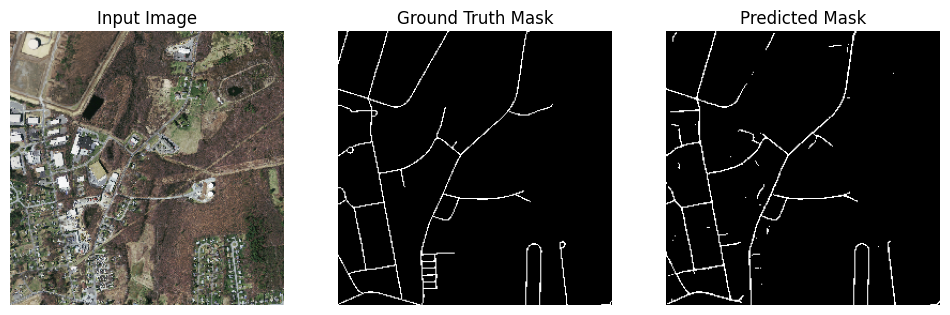

In [ ]:
visualize_predictions(test_ds, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Confusion Matrix:
[[3014584   45858]
 [  55056   95766]]

Metrics on Test Set:
Precision     : 0.6762
Recall        : 0.6350
F1 Score      : 0.6549
Dice Coefficient: 0.6549
IoU (calculated): 0.4869


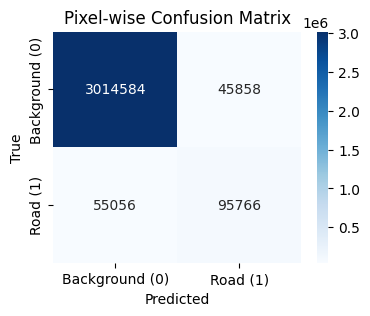

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true_list = []
y_pred_list = []

threshold = 0.5

for images, masks in test_ds:
    preds = model.predict(images)
    preds_bin = (preds > threshold).astype(np.uint8)
    y_true_list.append(masks.numpy().flatten())
    y_pred_list.append(preds_bin.flatten())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
dice = 2 * tp / (2 * tp + fp + fn)
iou = tp / (tp + fp + fn)

print(f"Confusion Matrix:\n{cm}")
print(f"\nMetrics on Test Set:")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU (calculated): {iou:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background (0)', 'Road (1)'],
            yticklabels=['Background (0)', 'Road (1)'])
plt.title("Pixel-wise Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score, cohen_kappa_score
import time

model = tf.keras.models.load_model('best_unet_roads.h5', custom_objects={'iou_metric': iou_metric}, compile=False)

y_true = []
y_pred = []

start = time.time()
for images, masks in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.uint8)
    y_true.append(masks.numpy().flatten())
    y_pred.append(preds.flatten())
end = time.time()

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

params = model.count_params()


prediction_time = (end - start) / len(test_imgs)

print("Precision:", round(precision,4))
print("Recall:", round(recall,4))
print("F1 Score:", round(f1,4))
print("IoU:", round(iou,4))
print("Accuracy:", round(acc,4))
print("Kappa:", round(kappa,4))
print("Parameters:", params)
print("Prediction Time (s/img):", round(prediction_time,4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Precision: 0.6762
Recall: 0.635
F1 Score: 0.6549
IoU: 0.4869
Accuracy: 0.9686
Kappa: 0.6385
Parameters: 31031745
Prediction Time (s/img): 0.1181
